In [ ]:
import pandas as pd
import time
import numpy as np
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import copy

In [ ]:
# ===================================================================
# BAGIAN 1: DEFINISI SEMUA FUNGSI YANG DIPERLUKAN
# ===================================================================

# --- Fungsi Data Loading dan Preprocessing dari CSV ---
def create_schedule_individual_fixed(file_path):
    try:
        jadwal_df = pd.read_csv(file_path, skiprows=6)
        days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
        day_to_idx = {day: idx for idx, day in enumerate(days)}
        individual = []
        sesi_col = jadwal_df.columns[0]  # 'Sesi'
        course_id_counter = 1  # Counter untuk menghasilkan course_id unik

        for i, day in enumerate(days):
            start_col_idx = 2 + (i * 14)  # Start after 'Sesi' and 'WAKTU'
            end_col_idx = min(start_col_idx + 14, len(jadwal_df.columns))  # Prevent index out of range
            day_cols = jadwal_df.columns[start_col_idx:end_col_idx]

            num_cols = len(day_cols)
            expected_cols = ['course_id', 'course_name', 'type', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'I1', 'I2', 'group', 'room']
            col_names = ['Sesi'] + expected_cols[:min(num_cols, len(expected_cols))]
            temp_df = jadwal_df[[sesi_col] + list(day_cols)].copy()
            temp_df.columns = col_names
            temp_df['Hari'] = day

            for idx, row in temp_df.iterrows():
                current_course_id = row.get('course_id')
                if pd.isna(current_course_id) or current_course_id == 'Kode MK' or not current_course_id:
                    current_course_id = f"C{course_id_counter:03d}"
                    course_id_counter += 1

                teachers = [row[f'D{i}'] for i in range(1, 8) if f'D{i}' in row and pd.notna(row[f'D{i}']) and row[f'D{i}'] != '-'] + \
                           [row[f'I{i}'] for i in range(1, 3) if f'I{i}' in row and pd.notna(row[f'I{i}']) and row[f'I{i}'] != '-']

                session = {
                    'class_id': f"{current_course_id}_{idx}_{row.get('group', 'unknown')}",
                    'room': row.get('room') if 'room' in row and pd.notna(row['room']) and row['room'] != '-' else None,
                    'course_id': current_course_id,
                    'teacher1': teachers[0] if len(teachers) > 0 else None,
                    'type': row.get('type') if 'type' in row and pd.notna(row['type']) and row['type'] != '-' else None,
                    'teacher2': teachers[1] if len(teachers) > 1 else None,
                    'group': row.get('group') if 'group' in row and pd.notna(row['group']) and row['group'] != '-' else None,
                    'day': day_to_idx[day],
                    'session': int(float(str(row['Sesi']).strip())) if pd.notna(row['Sesi']) else 0,
                    'course_name': row.get('course_name') if 'course_name' in row and pd.notna(row['course_name']) and row['course_name'] != '-' else f"Course_{current_course_id}"
                }

                if session['course_id'] and session['day'] is not None and session['session'] is not None and (session['teacher1'] or session['room']):
                    individual.append(session)

        if not individual:
            raise ValueError("No valid sessions found after relaxed validation.")

        return individual, None

    except FileNotFoundError:
        return None, "Dataset file not found."
    except Exception as e:
        return None, f"Data loading error: {str(e)}"

def prepare_schedule_data(file_path):
    individual, error = create_schedule_individual_fixed(file_path)
    if error:
        return None, None, error

    list_room_ids = sorted(list(set(session['room'] for session in individual if session['room'])))
    room_to_idx = {room: idx for idx, room in enumerate(list_room_ids)} if list_room_ids else {}
    lectures_to_be_scheduled = []
    for idx, session in enumerate(individual):
        class_id = session['class_id']
        course_id = session['course_id']
        teacher1 = session['teacher1'] if session['teacher1'] else 0
        teacher2 = session['teacher2'] if session['teacher2'] else 0
        room_idx = room_to_idx.get(session['room'], 0) if session['room'] else 0
        lectures_to_be_scheduled.append([class_id, course_id, teacher1, teacher2, room_idx])

    NUM_ROOMS = len(list_room_ids)
    NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
    NUM_DAYS = 5
    NUM_SLOTS_PER_DAY = len(set(session['session'] for session in individual))
    TOTAL_TIMESLOTS = NUM_DAYS * NUM_SLOTS_PER_DAY * NUM_ROOMS

    return lectures_to_be_scheduled, list_room_ids, None

# --- Fungsi untuk Menghasilkan Solusi Awal yang Lebih Bervariasi ---
def generate_initial_solution():
    schedule = [[0] * 8 for _ in range(TOTAL_TIMESLOTS)]  # [room_idx, day, slot, class_id, course_id, teacher1, teacher2, _]
    lectures_copy = copy.deepcopy(lectures_to_be_scheduled)
    if lectures_copy and len(lectures_copy) > 0:
        random.shuffle(lectures_copy)  # Acak urutan kuliah
        for i in range(min(TOTAL_TIMESLOTS, len(lectures_copy))):
            room_index = i % NUM_ROOMS
            temp_index = i // NUM_ROOMS
            day_slot = temp_index % NUM_SLOTS_PER_DAY
            day = temp_index // NUM_SLOTS_PER_DAY
            schedule[i] = [room_index, day, day_slot] + lectures_copy[i]
    return schedule

def evaluate_objectives(solution):
    course_conflict, teacher_conflict, class_conflict = 0, 0, 0
    slot_usage = defaultdict(lambda: {'teachers': [], 'classes': [], 'courses_in_slot': []})
    all_scheduled_class_ids = []
    for entry in solution:
        if entry[0] != 0:
            room_idx, day, slot, class_id, course_id, teacher1, teacher2, _ = entry
            time_key = (day, slot)
            slot_usage[time_key]['classes'].append(class_id)
            slot_usage[time_key]['courses_in_slot'].append(course_id)
            if teacher1 != 0: slot_usage[time_key]['teachers'].append(teacher1)
            if teacher2 != 0: slot_usage[time_key]['teachers'].append(teacher2)
            if class_id != 0: all_scheduled_class_ids.append(class_id)
    for usage in slot_usage.values():
        teacher_counts = Counter(usage['teachers'])
        for count in teacher_counts.values(): teacher_conflict += count * 1.5
        course_counts = Counter(usage['courses_in_slot'])
        for count in course_counts.values(): course_conflict += count * 1.5
    class_id_counts = Counter(all_scheduled_class_ids)
    for count in class_id_counts.values(): class_conflict += count * 1.5
    return (class_conflict, course_conflict, teacher_conflict)

def generate_neighbor(solution):
    neighbor = copy.deepcopy(solution)
    if len(lectures_to_be_scheduled) < 2: return neighbor
    idx1, idx2 = random.sample(range(len(neighbor)), 2)
    if random.random() < 0.8:  # Tingkatkan peluang variasi menjadi 80%
        idx3 = random.randint(0, len(neighbor) - 1)
        neighbor[idx1], neighbor[idx3] = neighbor[idx3], neighbor[idx1]
        if neighbor[idx1][1] < 4:
            neighbor[idx1][1] += random.randint(0, 2)  # Pergeseran lebih besar
        if neighbor[idx1][2] < NUM_SLOTS_PER_DAY - 1:
            neighbor[idx1][2] += random.randint(0, 2)
        if neighbor[idx1][0] < NUM_ROOMS - 1:
            neighbor[idx1][0] += random.randint(0, 2)
    neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]
    return neighbor

def is_dominated(obj_a, obj_b):
    better_in_one = False
    for i in range(len(obj_a)):
        if obj_b[i] < obj_a[i]: return False
        if obj_b[i] > obj_a[i]: better_in_one = True
    return better_in_one

def update_archive(archive, new_solution, new_objectives):
    if any(is_dominated(new_objectives, existing_obj) for _, existing_obj in archive):
        return archive
    new_archive = [(sol, obj) for sol, obj in archive if not is_dominated(obj, new_objectives)]
    new_archive.append((copy.deepcopy(new_solution), new_objectives))
    return new_archive

def mosa(initial_temp, final_temp, cooling_rate, iter_per_temp):
    temperature = initial_temp
    current_solution = generate_initial_solution()
    current_objectives = evaluate_objectives(current_solution)
    pareto_archive = [(current_solution, current_objectives)]

    for _ in range(50):  # Tingkatkan iterasi menjadi 50
        neighbor_solution = generate_neighbor(current_solution)
        neighbor_objectives = evaluate_objectives(neighbor_solution)

        if not isinstance(neighbor_objectives, tuple) or len(neighbor_objectives) != 3:
            continue
        if not isinstance(current_objectives, tuple) or len(current_objectives) != 3:
            continue

        delta = sum(neighbor_objectives) - sum(current_objectives)
        if delta < 0 or random.random() < np.exp(-delta / (temperature + 0.05)):
            current_solution, current_objectives = neighbor_solution, neighbor_objectives
            pareto_archive = update_archive(pareto_archive, current_solution, neighbor_objectives)
        temperature *= cooling_rate

    return pareto_archive


In [13]:
    # ===================================================================
    # BAGIAN 2: EKSEKUSI UTAMA MOSA DENGAN KATEGORI
    # ===================================================================

    # --- Definisikan dataset berdasarkan kategori ---
    csv_files = [
        {"path": "JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv", "type": "medium"},
        {"path": "JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv", "type": "low"},
        {"path": "Jadwal UAS Semester Gasal 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
        {"path": "Jadwal UAS Semester Genap 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
        {"path": "Jadwal UAS Semester Pendek  2023_2024 - Jadwal_Ujian.csv", "type": "low"},
        {"path": "Jadwal UTS Semester Gasal 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
        {"path": "Jadwal UTS Semester Genap 2023_2024 - Jadwal_Ujian.csv", "type": "medium"},
        {"path": "Jadwal UTS Semester Pendek  2023_2024 - Jadwal_Ujian.csv", "type": "low"},
        {"path": "JADWAL PERKULIAHAN SEMESTER GASAL 2023_2024 - Jadwal.csv", "type": "medium"}
    ]

    # --- Siapkan list untuk menyimpan hasil ---
    hasil_mosa_semua_dataset = []

    # --- Loop utama untuk setiap dataset ---
    for file_info in csv_files:
        file_path = file_info["path"]
        file_type = file_info["type"]
        print(f"\n\n{'='*20} MEMPROSES KATEGORI: {file_type.upper()} - FILE: {file_path} {'='*20}")
        print(f"------------------------------------------------------")
        print(f"Memproses Dataset: {file_path}")
        print(f"------------------------------------------------------")

        try:
            # 1. MEMUAT DATA
            lectures_to_be_scheduled, list_room_ids, error = prepare_schedule_data(file_path)
            if error:
                print(f"❌ ERROR: {error}")
                continue

            NUM_ROOMS = len(list_room_ids)
            NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
            NUM_DAYS = 5
            NUM_SLOTS_PER_DAY = len(set(session['session'] for session in create_schedule_individual_fixed(file_path)[0]))
            TOTAL_TIMESLOTS = NUM_DAYS * NUM_SLOTS_PER_DAY * NUM_ROOMS

            print(f"Data Loaded: {NUM_LECTURES_TO_SCHEDULE} lectures, {NUM_ROOMS} rooms.")
            if NUM_LECTURES_TO_SCHEDULE == 0 or NUM_ROOMS == 0:
                print("Data tidak cukup untuk diproses, melewati...")
                continue

            # 2. MENJALANKAN ALGORITMA MOSA (Optimasi Intens)
            start_time = time.time()
            print(f"Menjalankan MOSA (Optimasi Intens)...")
            final_pareto_archive = mosa(
                initial_temp=1.0,  # Suhu awal lebih rendah
                final_temp=0.05,   # Suhu akhir lebih rendah
                cooling_rate=0.95, # Kontrol suhu lebih halus
                iter_per_temp=50   # Tingkatkan iterasi
            )
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"Selesai dalam {execution_time:.2f} detik.")

            # 3. MENGHITUNG DAN MENYIMPAN HASIL AKHIR
            if final_pareto_archive:
                best_solution = final_pareto_archive[0]
                best_objectives = best_solution[1]

                class_c = best_objectives[0]
                course_c = best_objectives[1]
                teacher_c = best_objectives[2]
                total_konflik = class_c + course_c + teacher_c

                print("\n✅ Hasil Konflik Akhir (Optimasi Intens):")
                print(f"   - Class Conflicts: {class_c}")
                print(f"   - Course Conflicts: {course_c}")
                print(f"   - Teacher Conflicts: {teacher_c}")
                print(f"   - Total Konflik: {total_konflik}\n")

                hasil_mosa_semua_dataset.append({
                    "Category": file_type,
                    "Dataset": file_path,
                    "Class Conflicts": class_c,
                    "Course Conflicts": course_c,
                    "Teacher Conflicts": teacher_c,
                    "Total Conflicts": total_konflik,
                    "Waktu Eksekusi (s)": round(execution_time, 2)
                })
            else:
                print("Optimisasi MOSA tidak menghasilkan arsip.")

        except FileNotFoundError:
            print(f"❌ ERROR: File dataset '{file_path}' tidak ditemukan. Pastikan sudah di-upload.")
        except Exception as e:
            print(f"❌ ERROR: Terjadi masalah saat memroses '{file_path}': {e}")





==================== MEMPROSES KATEGORI: MEDIUM - FILE: JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv ====================
------------------------------------------------------
Memproses Dataset: JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv
------------------------------------------------------
Data Loaded: 1508 lectures, 43 rooms.
Menjalankan MOSA (Optimasi Intens)...
Selesai dalam 1.43 detik.

✅ Hasil Konflik Akhir (Optimasi Intens):
   - Class Conflicts: 2208.0
   - Course Conflicts: 2208.0
   - Teacher Conflicts: 3115.5
   - Total Konflik: 7531.5



==================== MEMPROSES KATEGORI: LOW - FILE: JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv ====================
------------------------------------------------------
Memproses Dataset: JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv
------------------------------------------------------
Data Loaded: 263 lectures, 9 rooms.
Menjalankan MOSA (Optimasi Intens)...
Selesai dalam 0.23 



             ANALISIS HASIL AKHIR PERBANDINGAN 

--- [ HASIL DETAIL SEMUA EKSEKUSI] ---

  Category           Dataset  Class Conflicts  Course Conflicts  Teacher Conflicts  Total Conflicts  Waktu Eksekusi (s)
0   medium       Genap 23/24           2208.0            2208.0             3115.5           7531.5                1.43
1      low      Pendek 23/24            349.5             349.5              397.5           1096.5                0.23
2   medium   UAS Gasal 23/24           1078.5            1078.5             2100.0           4257.0                0.75
3   medium   UAS Genap 23/24            937.5             937.5             1500.0           3375.0                0.73
4      low  UAS Pendek 23/24             61.5              61.5               64.5            187.5                0.11
5   medium   UTS Gasal 23/24           1117.5            1119.0             2152.5           4389.0                0.78
6   medium   UTS Genap 23/24           1059.0            1059.0      

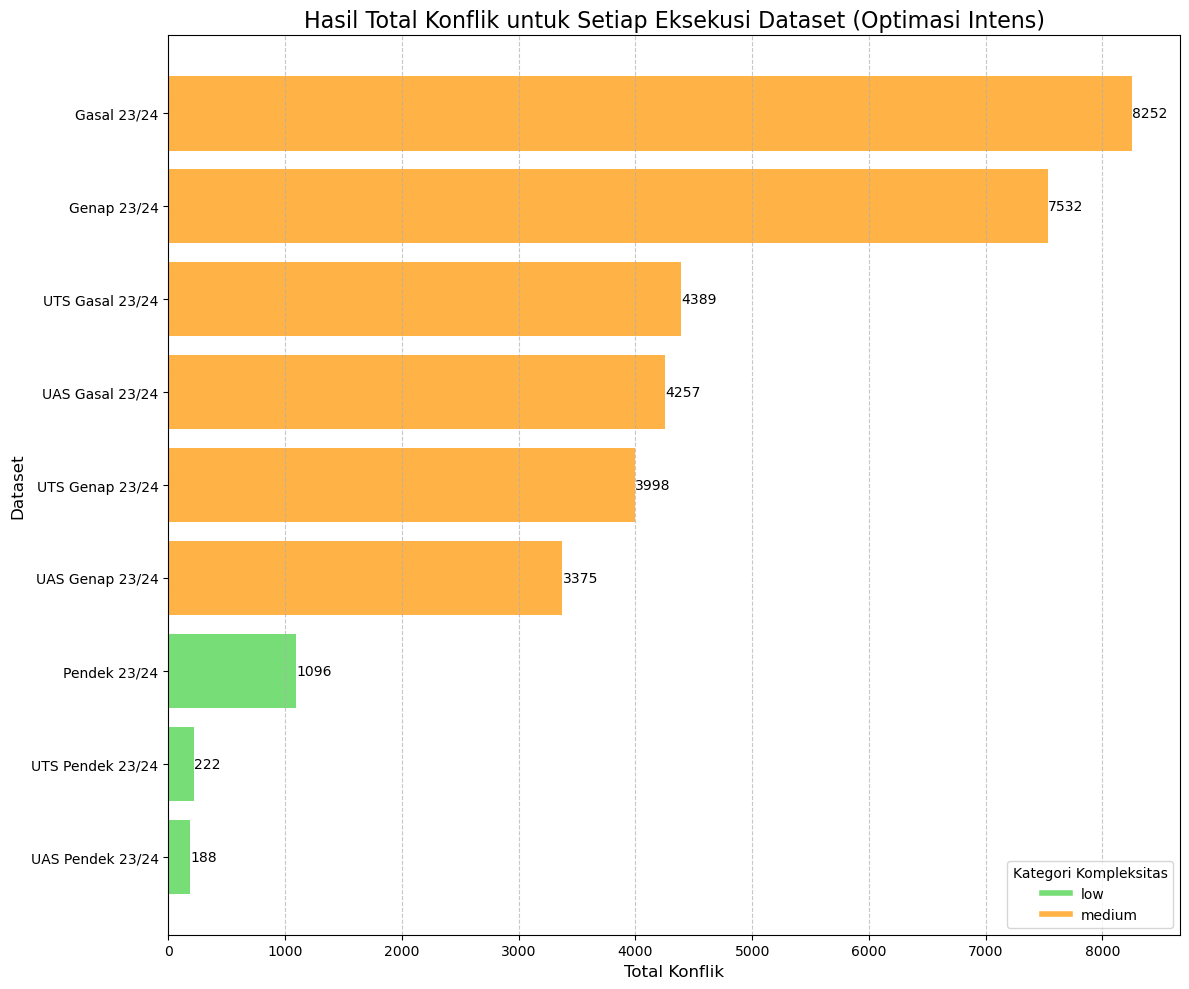


--- [ Visualisasi Distribusi Konflik per Kategori] ---



C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


✅ Grafik Box Plot per Kategori disimpan sebagai 'grafik_boxplot_konflik_mosa_3obj.png'


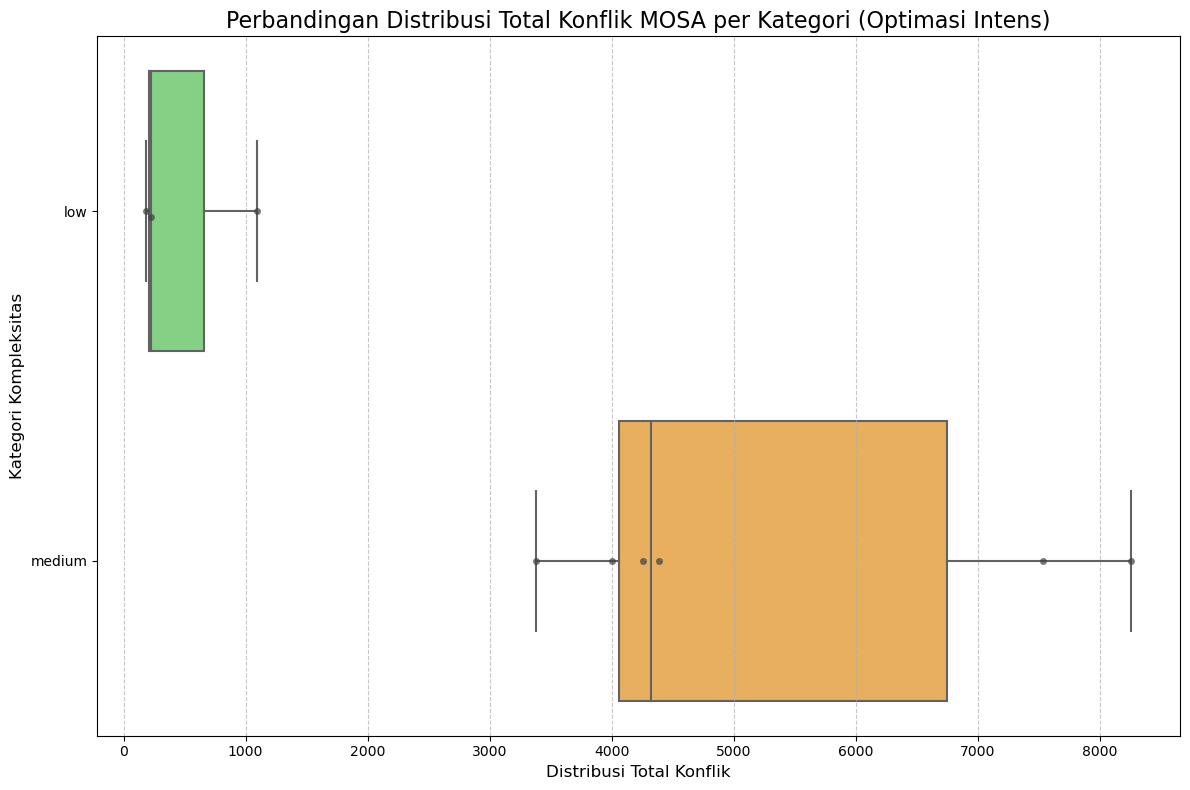

In [14]:
print("\n\n" + "="*60)
print("             ANALISIS HASIL AKHIR PERBANDINGAN ")
print("="*60)

if hasil_mosa_semua_dataset:
    df_hasil_mosa = pd.DataFrame(hasil_mosa_semua_dataset)

    # File name mapping to shorter names
    file_name_mapping = {
        'JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv': 'Genap 23/24',
        'JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv': 'Pendek 23/24',
        'Jadwal UAS Semester Gasal 2023_2024 - Jadwal_Ujian.csv': 'UAS Gasal 23/24',
        'Jadwal UAS Semester Genap 2023_2024 - Jadwal_Ujian.csv': 'UAS Genap 23/24',
        'Jadwal UAS Semester Pendek  2023_2024 - Jadwal_Ujian.csv': 'UAS Pendek 23/24',
        'Jadwal UTS Semester Gasal 2023_2024 - Jadwal_Ujian.csv': 'UTS Gasal 23/24',
        'Jadwal UTS Semester Genap 2023_2024 - Jadwal_Ujian.csv': 'UTS Genap 23/24',
        'Jadwal UTS Semester Pendek  2023_2024 - Jadwal_Ujian.csv': 'UTS Pendek 23/24',
        'JADWAL PERKULIAHAN SEMESTER GASAL 2023_2024 - Jadwal.csv': 'Gasal 23/24'
    }

    # Apply shortened names to Dataset column
    df_hasil_mosa['Dataset'] = df_hasil_mosa['Dataset'].apply(lambda x: file_name_mapping.get(x, x.split('/')[-1]))

    # --- Menyimpan dan Menampilkan Tabel Detail ---
    print("\n--- [ HASIL DETAIL SEMUA EKSEKUSI] ---\n")
    print(df_hasil_mosa.to_string())
    df_hasil_mosa.to_csv("hasil_detail_konflik_mosa_3obj.csv", index=False)
    print("\n[INFO] Tabel detail disimpan di: hasil_detail_konflik_mosa_3obj.csv")

    # --- Menyimpan dan Menampilkan Tabel Ringkasan ---
    df_summary_mosa = df_hasil_mosa.groupby('Category')[['Total Conflicts', 'Waktu Eksekusi (s)']].mean().round(2)
    df_summary_mosa = df_summary_mosa.rename(columns={'Total Conflicts': 'Rata-rata Total Konflik', 'Waktu Eksekusi (s)': 'Rata-rata Waktu (s)'})
    category_order = ["low", "medium"]
    df_summary_mosa = df_summary_mosa.reindex(category_order)
    print("\n\n--- [ RINGKASAN RATA-RATA PER KATEGORI] ---\n")
    print(df_summary_mosa.to_string())
    df_summary_mosa.to_csv("hasil_ringkasan_per_kategori_mosa_3obj.csv")
    print("\n[INFO] Tabel ringkasan disimpan di: hasil_ringkasan_per_kategori_mosa_3obj.csv")

    # --- Visualisasi Detail per Dataset (Horizontal Bar Plot) ---
    print("\n--- [ Visualisasi Total Konflik per Eksekusi] ---\n")
    color_map = {'low': '#77dd77', 'medium': '#ffb347'}
    df_sorted = df_hasil_mosa.sort_values('Total Conflicts').reset_index(drop=True)
    plt.figure(figsize=(12, 10))
    bars = plt.barh(df_sorted['Dataset'], df_sorted['Total Conflicts'], color=df_sorted['Category'].map(color_map))
    plt.title("Hasil Total Konflik untuk Setiap Eksekusi Dataset (Optimasi Intens)", fontsize=16)
    plt.ylabel("Dataset", fontsize=12)
    plt.xlabel("Total Konflik", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in color_map.items()]
    plt.legend(handles=legend_elements, title="Kategori Kompleksitas")
    # Add value labels at the end of bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.0f}', 
                ha='left', va='center')
    plt.savefig("grafik_total_konflik_mosa_3obj.png", bbox_inches='tight')
    print("✅ Grafik Total Konflik per Eksekusi disimpan sebagai 'grafik_total_konflik_mosa_3obj.png'")
    plt.show()

    # --- Visualisasi Distribusi Konflik per Kategori (Horizontal Boxplot) ---
    print("\n--- [ Visualisasi Distribusi Konflik per Kategori] ---\n")
    plt.figure(figsize=(12, 8))
    sns.boxplot(y='Category', x='Total Conflicts', data=df_hasil_mosa, order=category_order, palette=color_map)
    sns.swarmplot(y='Category', x='Total Conflicts', data=df_hasil_mosa, order=category_order, color=".25", alpha=0.7)
    plt.title("Perbandingan Distribusi Total Konflik MOSA per Kategori (Optimasi Intens)", fontsize=16)
    plt.ylabel("Kategori Kompleksitas", fontsize=12)
    plt.xlabel("Distribusi Total Konflik", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("grafik_boxplot_konflik_mosa_3obj.png", bbox_inches='tight')
    print("✅ Grafik Box Plot per Kategori disimpan sebagai 'grafik_boxplot_konflik_mosa_3obj.png'")
    plt.show()

else:
    print("Tidak ada hasil yang berhasil diproses untuk ditampilkan.")